In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [3]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-n49sqbw0
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-n49sqbw0
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [4]:
# Load STL-10 dataset with appropriate transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match CLIP input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [5]:
# Load STL-10 training dataset
stl10_train = torchvision.datasets.STL10(root="./data", split='train', download=True, transform=transform)

In [6]:
# Create a DataLoader
stl10_loader = DataLoader(stl10_train, batch_size=8, shuffle=True)

In [7]:
# Check dataset
images, labels = next(iter(stl10_loader))
print(f"Loaded batch of images with shape: {images.shape}")

Loaded batch of images with shape: torch.Size([8, 3, 224, 224])


In [8]:
import clip
from PIL import Image

# Check if CUDA (GPU) is available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the CLIP model
model, preprocess = clip.load("ViT-B/32", device=device)

print("CLIP model loaded successfully!")

CLIP model loaded successfully!


In [9]:
# Define class labels for zero-shot classification
class_labels = ["airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck"]

# Tokenize the class labels using CLIP's tokenizer
text_inputs = clip.tokenize(class_labels).to(device)

print("Class labels tokenized for zero-shot classification!")

Class labels tokenized for zero-shot classification!


In [10]:
# Get a batch of images from STL-10 dataset
images, _ = next(iter(stl10_loader))
images = images.to(device)

# Encode images using CLIP's image encoder
image_features = model.encode_image(images)

# Encode text labels using CLIP's text encoder
text_features = model.encode_text(text_inputs)

# Normalize features
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

# Compute similarity scores between images and text labels
similarity = image_features @ text_features.T  # (batch_size x num_classes)

# Get the predicted class for each image
predicted_class_indices = similarity.argmax(dim=-1)

# Map indices to class labels
predicted_labels = [class_labels[idx] for idx in predicted_class_indices]

print("Predicted labels for the batch:", predicted_labels)

Predicted labels for the batch: ['monkey', 'car', 'monkey', 'cat', 'monkey', 'bird', 'bird', 'bird']


In [12]:
correct = 0
total = 0

for images, labels in stl10_loader:
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():  # Disable gradients to save memory
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        similarity = image_features @ text_features.T
        predicted_class_indices = similarity.argmax(dim=-1)

        correct += (predicted_class_indices == labels).sum().item()
        total += labels.size(0)

    del images, labels, image_features, similarity  # Free up memory
    torch.cuda.empty_cache()  # Clear GPU cache

    if total >= 500:  # Stop early for testing
        break

accuracy = (correct / total) * 100
print(f"Zero-Shot Classification Accuracy: {accuracy:.2f}%")


Zero-Shot Classification Accuracy: 94.25%


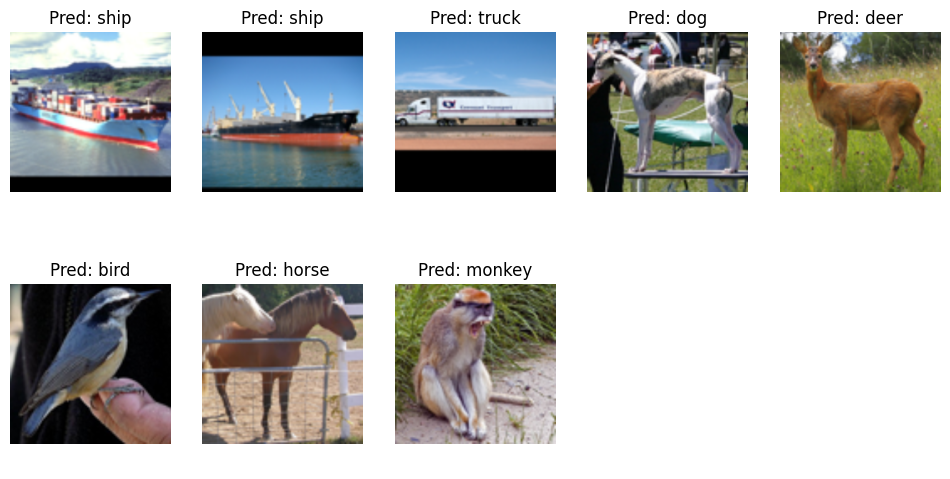

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images
images, _ = next(iter(stl10_loader))
images = images.to(device)

# Encode images
with torch.no_grad():
    image_features = model.encode_image(images)
    image_features /= image_features.norm(dim=-1, keepdim=True)

    text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    similarity = image_features @ text_features.T
    predicted_class_indices = similarity.argmax(dim=-1)

# Convert images to CPU for plotting
images = images.cpu().numpy().transpose(0, 2, 3, 1)  # (B, H, W, C)
images = (images * 0.5) + 0.5  # Denormalize

# Dynamically adjust the number of subplots
batch_size = images.shape[0]
cols = min(5, batch_size)  # Max 5 columns
rows = (batch_size + cols - 1) // cols  # Calculate rows needed

fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
axes = axes.flatten() if rows > 1 else [axes]

for i in range(batch_size):
    axes[i].imshow(images[i])
    axes[i].set_title(f"Pred: {class_labels[predicted_class_indices[i]]}")
    axes[i].axis("off")

# Hide any unused subplots
for i in range(batch_size, len(axes)):
    axes[i].axis("off")

plt.show()

In [15]:
import torch.nn as nn

# Define a new classification head
class CLIPFineTune(nn.Module):
    def __init__(self, clip_model, num_classes=10):
        super(CLIPFineTune, self).__init__()
        self.clip_model = clip_model
        self.fc = nn.Linear(512, num_classes)  # 512 is CLIP's feature size for ViT-B/32

    def forward(self, images):
        with torch.no_grad():  # Freeze CLIP's image encoder
            features = self.clip_model.encode_image(images)

        features = features / features.norm(dim=-1, keepdim=True)  # Normalize
        return self.fc(features)  # Classification head

# Initialize fine-tuned model
fine_tune_model = CLIPFineTune(model, num_classes=10).to(device)
print("Fine-tuning model initialized!")


Fine-tuning model initialized!


In [16]:
import torch.optim as optim

# Define loss function (CrossEntropy for classification)
criterion = nn.CrossEntropyLoss()

# Define optimizer (Adam for efficient updates)
optimizer = optim.Adam(fine_tune_model.fc.parameters(), lr=0.001)  # Only train classifier head


In [17]:
# Training loop
num_epochs = 5  # Adjust as needed
fine_tune_model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in stl10_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Reset gradients

        outputs = fine_tune_model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss

        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        running_loss += loss.item()

    # Print epoch stats
    epoch_loss = running_loss / len(stl10_loader)
    epoch_acc = (correct / total) * 100
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

print("Training complete!")

Epoch [1/5], Loss: 1.5793, Accuracy: 91.74%
Epoch [2/5], Loss: 0.7174, Accuracy: 97.54%
Epoch [3/5], Loss: 0.3928, Accuracy: 97.70%
Epoch [4/5], Loss: 0.2568, Accuracy: 97.68%
Epoch [5/5], Loss: 0.1878, Accuracy: 97.82%
Training complete!


In [19]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations (same as training for consistency)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match CLIP input
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize as done before
])

# Load STL-10 Test Set
stl10_test = datasets.STL10(root="./data", split="test", download=True, transform=transform)

# Create DataLoader
stl10_test_loader = DataLoader(stl10_test, batch_size=32, shuffle=False)

In [20]:
# Switch model to evaluation mode
fine_tune_model.eval()

correct = 0
total = 0
running_loss = 0.0

with torch.no_grad():  # Disable gradient computation for testing
    for images, labels in stl10_test_loader:  # Load test data
        images, labels = images.to(device), labels.to(device)

        outputs = fine_tune_model(images)  # Get model predictions
        loss = criterion(outputs, labels)  # Compute loss
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)  # Get class with highest score
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# Compute final accuracy & loss
test_loss = running_loss / len(stl10_test_loader)
test_accuracy = (correct / total) * 100

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.1655, Test Accuracy: 97.89%


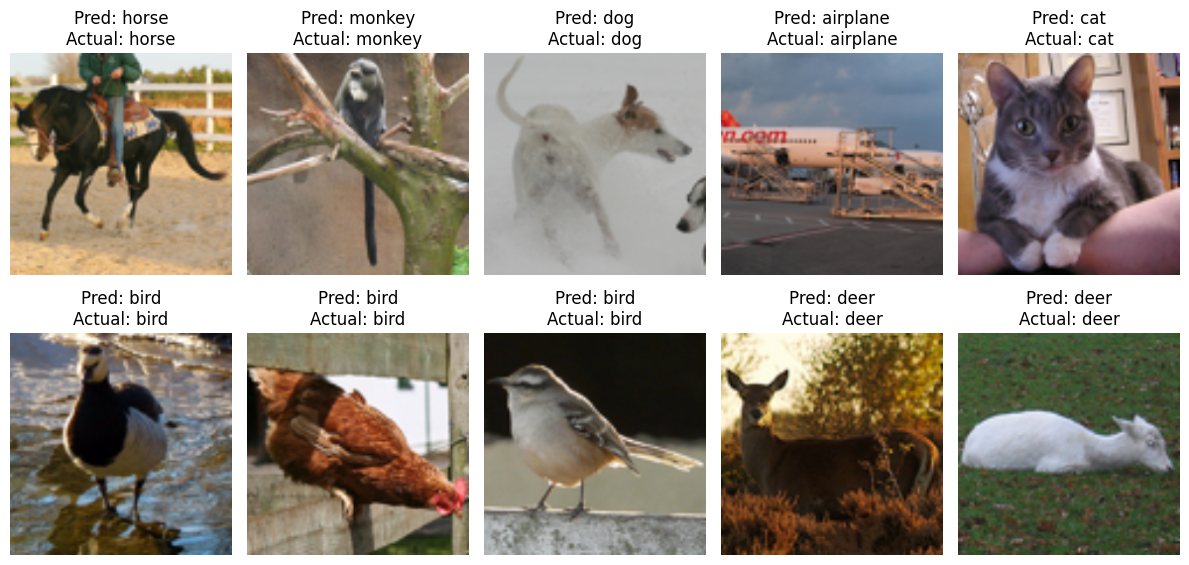

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of test images & labels
data_iter = iter(stl10_test_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

# Get model predictions
fine_tune_model.eval()
with torch.no_grad():
    outputs = fine_tune_model(images)
    _, predicted = torch.max(outputs, 1)

# Class labels for STL-10
class_labels = [
    "airplane", "bird", "car", "cat", "deer",
    "dog", "horse", "monkey", "ship", "truck"
]

# Plot images with predictions
fig, axes = plt.subplots(2, 5, figsize=(12, 6))  # Create a 2x5 grid
axes = axes.flatten()

for i in range(10):  # Show 10 images
    img = images[i].cpu().permute(1, 2, 0).numpy()  # Convert tensor to image
    img = (img * 0.5) + 0.5  # Unnormalize

    axes[i].imshow(img)
    axes[i].set_title(f"Pred: {class_labels[predicted[i].item()]}\nActual: {class_labels[labels[i].item()]}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [24]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=c8bb4a1981fb38e3da57156afc49547d83a1d12043afe5d007afa919726edf26
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


  0%|          | 0/1000 [00:00<?, ?it/s]

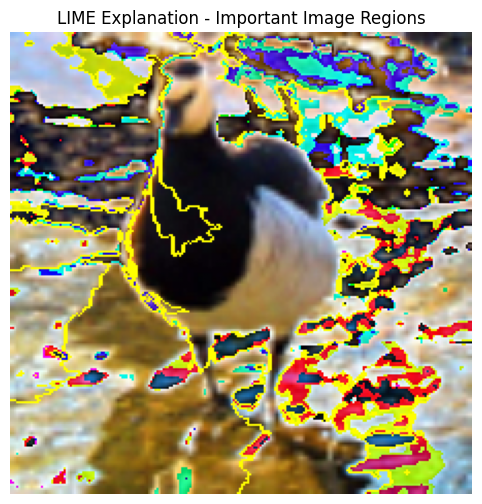

In [26]:
import torch
import clip
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from torchvision.transforms.functional import to_pil_image
from PIL import Image

# Load CLIP Model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device)

# Define STL-10 Class Labels
class_labels = [
    "airplane", "bird", "car", "cat", "deer",
    "dog", "horse", "monkey", "ship", "truck"
]

# Load an image from STL-10 test set
image, _ = stl10_test[5]  # Change index to test different images
image_pil = to_pil_image(image)  # Convert tensor to PIL image

# Preprocess Image for CLIP
transform = Compose([
    Resize((224, 224)),
    CenterCrop(224),
    ToTensor(),
    Normalize(mean=(0.5,), std=(0.5,))
])

image_input = transform(image_pil).unsqueeze(0).to(device)

# Define Function for LIME Explanation
def predict_fn(images):
    images = torch.stack([transform(Image.fromarray(img)) for img in images]).to(device)
    with torch.no_grad():
        logits_per_image, _ = model(images, clip.tokenize(class_labels).to(device))
    return logits_per_image.softmax(dim=1).cpu().numpy()

# LIME Explanation
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    np.array(image_pil), predict_fn, top_labels=1, hide_color=0, num_samples=1000
)

# Get Explanation Mask
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False
)

# Show Image with Explanation
plt.figure(figsize=(8, 6))
plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation - Important Image Regions")
plt.axis("off")
plt.show()

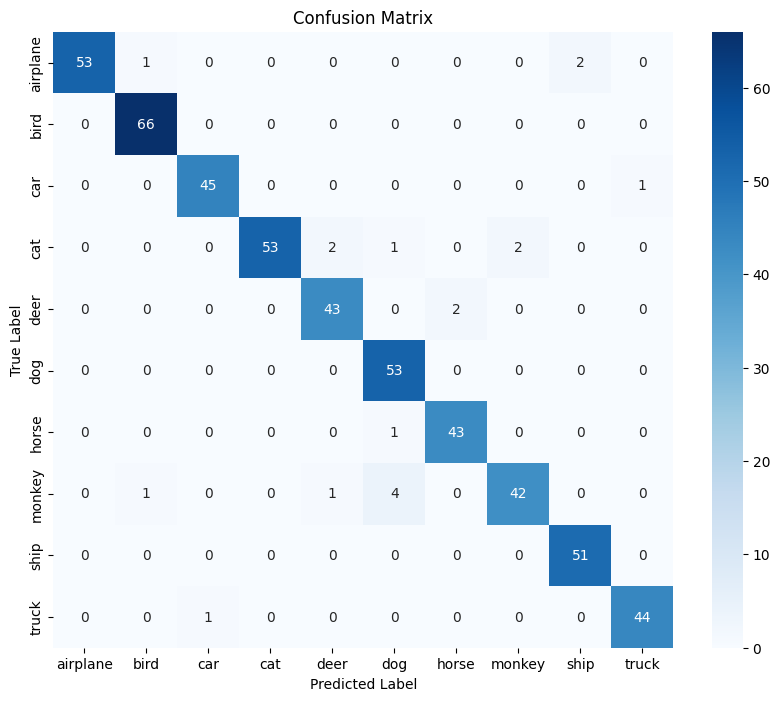

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [32]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

    airplane       1.00      0.95      0.97        56
        bird       0.97      1.00      0.99        66
         car       0.98      0.98      0.98        46
         cat       1.00      0.91      0.95        58
        deer       0.93      0.96      0.95        45
         dog       0.90      1.00      0.95        53
       horse       0.96      0.98      0.97        44
      monkey       0.95      0.88      0.91        48
        ship       0.96      1.00      0.98        51
       truck       0.98      0.98      0.98        45

    accuracy                           0.96       512
   macro avg       0.96      0.96      0.96       512
weighted avg       0.96      0.96      0.96       512



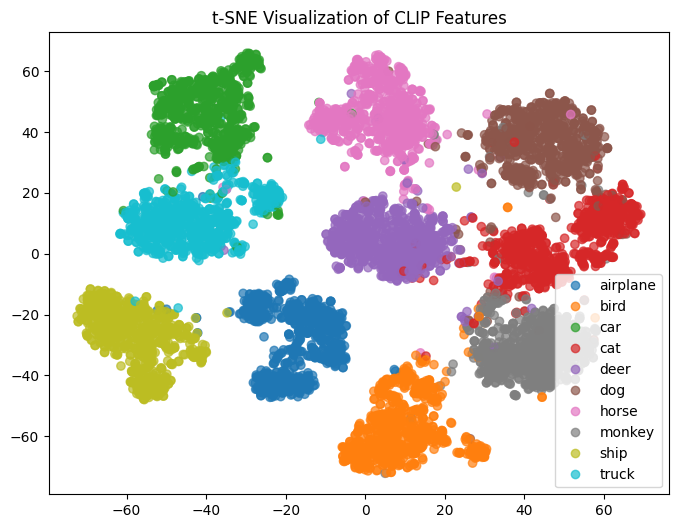

In [34]:
from sklearn.manifold import TSNE
import numpy as np

# Extract feature embeddings
features, labels_list = [], []

with torch.no_grad():
    for images, labels in stl10_test_loader:
        images = images.to(device)

        # Get CLIP embeddings
        image_features = model.encode_image(images)
        features.append(image_features.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

# Convert to NumPy
features = np.concatenate(features, axis=0)

# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_2d = tsne.fit_transform(features)

# Plot t-SNE
plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels_list, cmap="tab10", alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=class_labels)
plt.title("t-SNE Visualization of CLIP Features")
plt.show()

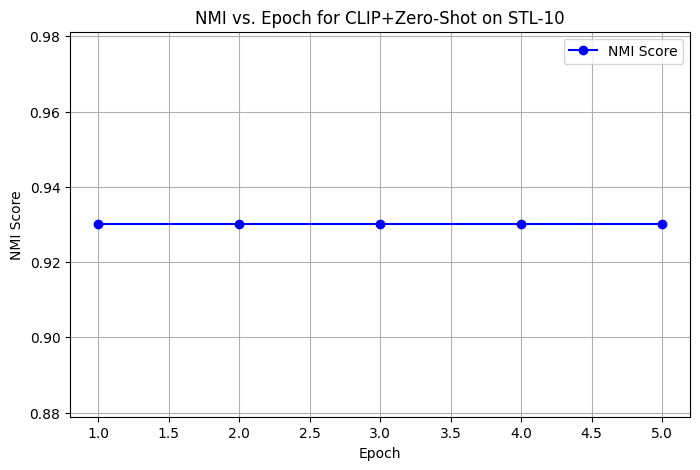

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score

# Initialize NMI storage
nmi_scores = []

# Assuming these are stored after each epoch
for epoch in range(num_epochs):
    # Compute NMI using ground truth labels and predicted labels
    nmi = normalized_mutual_info_score(y_true, y_pred, average_method="arithmetic")
    nmi_scores.append(nmi)

# Plot the NMI vs Epoch graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(nmi_scores) + 1), nmi_scores, marker="o", linestyle="-", color="b", label="NMI Score")
plt.xlabel("Epoch")
plt.ylabel("NMI Score")
plt.title("NMI vs. Epoch for CLIP+Zero-Shot on STL-10")
plt.legend()
plt.grid()
plt.show()


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [02:38, 158.64s/it]              


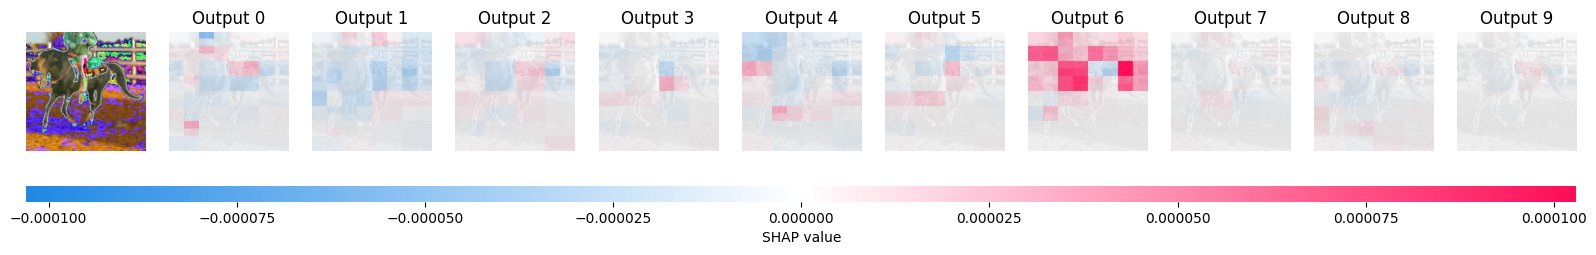

In [37]:
import shap
import numpy as np
import torch
import clip
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# Load CLIP Model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Load an image from STL-10
image, label = next(iter(stl10_test_loader))  # Get a batch
image = image[0].to(device)  # Select first image

# Convert tensor to PIL Image for SHAP
image_pil = transforms.ToPILImage()(image.cpu())

# Convert PIL image to NumPy array
image_np = np.array(image_pil)

# Define function for SHAP
def clip_predict(images):
    images = torch.stack([preprocess(Image.fromarray(img.astype("uint8"))) for img in images]).to(device)
    with torch.no_grad():
        logits_per_image, _ = model(images, clip.tokenize(class_labels).to(device))
    return logits_per_image.softmax(dim=-1).cpu().numpy()

# Create SHAP Explainer using Image masker
masker = shap.maskers.Image("inpaint_telea", image_np.shape)

explainer = shap.Explainer(clip_predict, masker)

# Generate SHAP values
shap_values = explainer(image_np.reshape(1, *image_np.shape))

# Visualize SHAP explanation
shap.image_plot(shap_values)


In [39]:
import shap
import torch
import clip
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Load CLIP Model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()  # Set model to evaluation mode

# Load an image from STL-10
image, label = next(iter(stl10_test_loader))  # Get a batch
image = image[0].to(device)  # Select first image

# Convert tensor image to numpy array for SHAP
transform_to_pil = transforms.ToPILImage()
image_pil = transform_to_pil(image.cpu())  # Convert tensor to PIL Image
image_np = preprocess(image_pil).unsqueeze(0).to(device)  # Preprocess for CLIP

# Define background for SHAP (use a few images from STL-10 as baseline)
background_images = []
for _ in range(10):  # Select 10 background images
    img_batch, _ = next(iter(stl10_test_loader))
    img = img_batch[0]  # Select the first image
    img_pil = transform_to_pil(img.cpu())  # Convert to PIL


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [02:40, 160.34s/it]              
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:1633: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


TypeError: Invalid shape (224, 4, 0) for image data

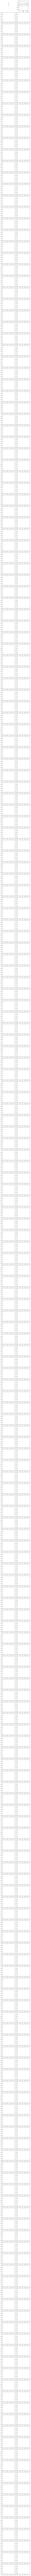

In [43]:
import shap
import torch
import clip
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Load CLIP Model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()

# Load an image from STL-10
image, label = next(iter(stl10_test_loader))  # Get a batch
image = image[0].to(device)  # Select first image

# Convert tensor to PIL Image
transform_to_pil = transforms.ToPILImage()
image_pil = transform_to_pil(image.cpu())

# Convert PIL image to NumPy array with correct shape (H, W, 3)
image_np = np.array(image_pil)
if len(image_np.shape) == 2:  # Convert grayscale to RGB
    image_np = np.stack([image_np] * 3, axis=-1)

# Define prediction function for SHAP
def clip_predict(images):
    images = torch.stack([preprocess(Image.fromarray(img.astype("uint8"))) for img in images]).to(device)
    with torch.no_grad():
        logits_per_image, _ = model(images, clip.tokenize(class_labels).to(device))
    return logits_per_image.softmax(dim=-1).cpu().numpy()

# Define SHAP masker
masker = shap.maskers.Image("inpaint_telea", image_np.shape)

# Create SHAP Explainer
explainer = shap.Explainer(clip_predict, masker)

# Generate SHAP values
shap_values = explainer(image_np.reshape(1, *image_np.shape))

# ✅ Fix: Reshape SHAP values for single-class visualization
shap_values_fixed = [shap_values]

# Display SHAP Explanation
shap.image_plot(shap_values_fixed, image_np)